Este notebook tem como propósito testar o impacto da **redução de dimensionalidade** de **series temporais** univariadas na acurácia de diferentes classificadores. Para isso será testado a implementação de diferentes abordagens, como variações do algorítimo **PAA** (Piecewise Aggregate Approximation) utilizando estratégias de **pooling**, e também através de técnicas basedas em **Autoencoders**.

In [228]:
# Importa alguns pacotes úteis
import pandas as pd
import numpy as np
import time
import os
import warnings

Iniciamos explorando a utilização e manipulação de datasets de series temporais de benchmarking da biblioteca **aeon**. Exemplificando como carregar os datasets e como eles são armazenados.

In [2]:
# Importa uma lista de nomes de datasets de series temporais univariadas comumente utilizados em testes de benchamarking
from aeon.datasets.tsc_datasets import univariate as datasets

print(f"Lista com o nome dos {len(datasets)} datasets de benchmarking: \n{datasets}")

Lista com o nome dos 128 datasets de benchmarking: 
['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'BME', 'Car', 'CBF', 'Chinatown', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate'

In [3]:
# Para obter os dados de um dataset, precisamos carrega-lo em memória utilizando a função load_classification dísponível na biblioteca aeon
from aeon.datasets import load_classification

# Neste exemplo, utilizaremos o dataset "HouseTwenty" (disponível na lista de datasets carregada anteriormente)
dataset_name = 'HouseTwenty'

X_train, y_train = load_classification(dataset_name, split="train")
X_test, y_test = load_classification(dataset_name, split="test")

# Cada conjunto de dados carregado é composto por uma matriz 3D contendo: (n_intâncias, n_features, n_pontos) e um vetor 1D para as classes (labels)
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print()
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (40, 1, 2000)
y_train: (40,)

X_test: (119, 1, 2000)
y_test: (119,)


**Nota:** Podemos obter o tamanho (dimensionalidade) de uma série temporal selecionando o terceiro valor (`idx = 2`) dos dados carregados. No exemplo acima, o dataset **"HouseTwenty"** possui 159 séries (40 de treino + 119 de teste) de **2000 pontos (dimensões)**.

Como o escopo deste notebook só considera séries univariadas, o segundo valor (`idx = 1`) dos dados será sempre **1**, pois são séries de somente uma classe/feature.

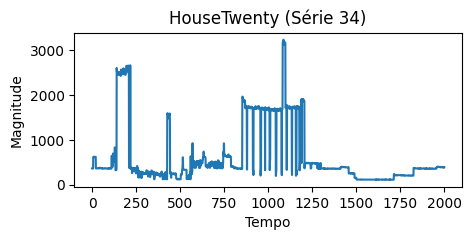

In [4]:
# Podemos plotar uma série temporal para visualização usando o matplotlib
import matplotlib.pyplot as plt

# Neste exemplo, plotamos uma instância qualquer (índice 34) da série do conjunto de treino que carregamos anteriormente do dataset "HouseTwenty"
idx = 34
serie = X_train[idx, 0, :] # Seleciona a série temporal da instância 34, feature 0 (única feature, pois é univariada)

plt.figure(figsize=(5,2))
plt.plot(serie) # Aqui selecionamos a série temporal da instância 34, feature 0 (única feature, pois é univariada) e todos os pontos (:)
plt.title(f"{dataset_name} (Série {idx})")
plt.xlabel("Tempo")
plt.ylabel("Magnitude")
plt.show()

In [5]:
high_dim_datasets = [
    "ACSF1",
    "CinCECGTorso",
    "EOGHorizontalSignal",
    "EOGVerticalSignal",
    "EthanolLevel",
    "HandOutlines",
    "Haptics",
    "HouseTwenty",
    "InlineSkate",
    "Mallat",
    "MixedShapesRegularTrain",
    "MixedShapesSmallTrain",
    "Phoneme",
    "PigAirwayPressure",
    "PigArtPressure",
    "PigCVP",
    "Rock",
    "SemgHandGenderCh2",
    "SemgHandMovementCh2",
    "SemgHandSubjectCh2",
    "StarLightCurves",
]

In [ ]:
# Para testar a redução de dimensionalidade das series destes datasets, é preciso selecionar series que possuam alta dimensionalidade (>=1000 pontos)
# Para isso, definimos uma lista para armazenar os nomes dos datasets que atendem a este critério

# A fim de verificar a dimensionalidade de cada dataset, iteramos sobre a lista de nomes de datasets originais (pode demorar alguns minutos).
high_dim_datasets = []
for d in datasets:
  X, y = load_classification(d, split='train')
  
  # Podem existir datasets que são implementados com diferentes formatos, sem ser Arrays do Numpy ou DataFrames, então usamos um bloco try-except para evitar erros ao tentar acessar o '.shape'
  try:
    if X.shape[2] >= 1000:
      print(f"{d}: {X.shape[2]}")
      high_dim_datasets.append(d)
  except AttributeError:
    pass

print(f"\n\nLista com o nome dos {len(high_dim_datasets)} datasets de benchmarking com séries univariadas e alta dimensionalidade (>=1000 pontos): \n{high_dim_datasets}")

ACSF1: 1460
CinCECGTorso: 1639
EOGHorizontalSignal: 1250
EOGVerticalSignal: 1250
EthanolLevel: 1751
HandOutlines: 2709
Haptics: 1092
HouseTwenty: 2000
InlineSkate: 1882
Mallat: 1024
MixedShapesRegularTrain: 1024
MixedShapesSmallTrain: 1024
Phoneme: 1024
PigAirwayPressure: 2000
PigArtPressure: 2000
PigCVP: 2000
Rock: 2844
SemgHandGenderCh2: 1500
SemgHandMovementCh2: 1500
SemgHandSubjectCh2: 1500
StarLightCurves: 1024
Lista com o nome dos 21 datasets de benchmarking com séries univariadas e alta dimensionalidade (>=1000 pontos): 
['ACSF1', 'CinCECGTorso', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'EthanolLevel', 'HandOutlines', 'Haptics', 'HouseTwenty', 'InlineSkate', 'Mallat', 'MixedShapesRegularTrain', 'MixedShapesSmallTrain', 'Phoneme', 'PigAirwayPressure', 'PigArtPressure', 'PigCVP', 'Rock', 'SemgHandGenderCh2', 'SemgHandMovementCh2', 'SemgHandSubjectCh2', 'StarLightCurves']


In [6]:
# Para treinar e testar classificadores, podemos utilizar a implementação de diferentes modelos disponíveis na biblioteca aeon
from aeon.classification.convolution_based import RocketClassifier
from aeon.classification.feature_based import Catch22Classifier
# Tambem podemos medir a acurácia (taxa de acerto) dos classificadores utilizando a biblioteca sklearn
from sklearn.metrics import accuracy_score

# Neste exemplo iremos treinar um classificar Rocket e medir sua acurácia no dataset "HouseTwenty" que carregamos anteriormente
# Tambem mediremos o tempo gasto para treinar o classificador utilizando o pacote 'time' importado no início deste notebook
start = time.time()
clf = RocketClassifier(n_kernels=10000, random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
end = time.time()

# Calcula o tempo gasto (em segundos) para treinar e testar o classificador (arredondado para 2 casas decimais)
elapsed = np.round(end - start, 2)

# Mede a acurácia das predições utilizando a função accuracy_score da biblioteca sklearn
acc = np.round(accuracy_score(y_test, predictions), 4)

print(f"-> Classificador Rocket\n\tDataset: HouseTwenty\n\tAcurácia: {acc}\n\tTempo gasto: {elapsed} segundos")


-> Classificador Rocket
	Dataset: HouseTwenty
	Acurácia: 0.9664
	Tempo gasto: 34.45 segundos


Na sequência iremos implementar a adaptaçao do algoritimo do **PAA** adaptado para receber o método a ser usado na agregação dos dados. Para facilitar futuras iterações e adaptações começaremos definindo os métodos de agregação que iremos trabalhar.

In [ ]:
# Definimos uma lista de funções de agregação que serão aboradadas para a redução de dimensionalidade das séries temporais
aggregations = {
    'average': lambda x: np.mean(x),
    'max': lambda x: np.max(x),
    'min': lambda x: np.min(x),
    'sum': lambda x: np.sum(x),
    'variance': lambda x: np.var(x),
    'std': lambda x: np.std(x),
    'iqr': lambda x: np.subtract(*np.percentile(x, [75, 25])),
    'first': lambda x: x[0],
    'central': lambda x: x[len(x)//2],
    'last': lambda x: x[-1],
    'max-min': lambda x: np.max(x) - np.min(x),
    'avg-max': lambda x: np.abs((np.mean(x) - np.max(x))),
    'avg-min': lambda x: np.abs((np.mean(x) - np.min(x))),
    'random': lambda x: np.random.choice(x)
}

In [14]:
# Aqui implemetamos a adaptação do algorítmo PAA para receber o método de agregação como argumento.
# Além do argumento 'agg' que define a função de agregação, o PAA recebe como argumentos a série temporal 's' que será reduzida e o novo tamanho 'w' desejado.
def PAA(s, w, agg='average'):
    if agg not in aggregations:
        raise ValueError(f"Função de agregação '{agg}' é inválida ou não suportada.")

    n = len(s)
    s = np.array(s)

    # Aqui criamos n valores uniformemente espaçados entre 0 e w (exclusivo).
    # Por exemplo: n=6 e w=2 será [0,0,0,1,1,1]
    idx = np.floor(np.linspace(0, w, n, endpoint=False)).astype(int)

    # Aqui iteramos sobre o tamanho desejado 'w' e aplicamos uma máscara para selecionar os pontos da série que pertencem a cada segmento.
    # Por exemplo: n=6 e w=2, o idx resultante será: 
    #              [True, True, True, False, False, False] para w = 0
    #              Assim podemos selecionar os pontos da série que pertencem a cada segmento.
    res = [aggregations[agg](s[idx == i]) for i in range(w)]

    return np.array(res)

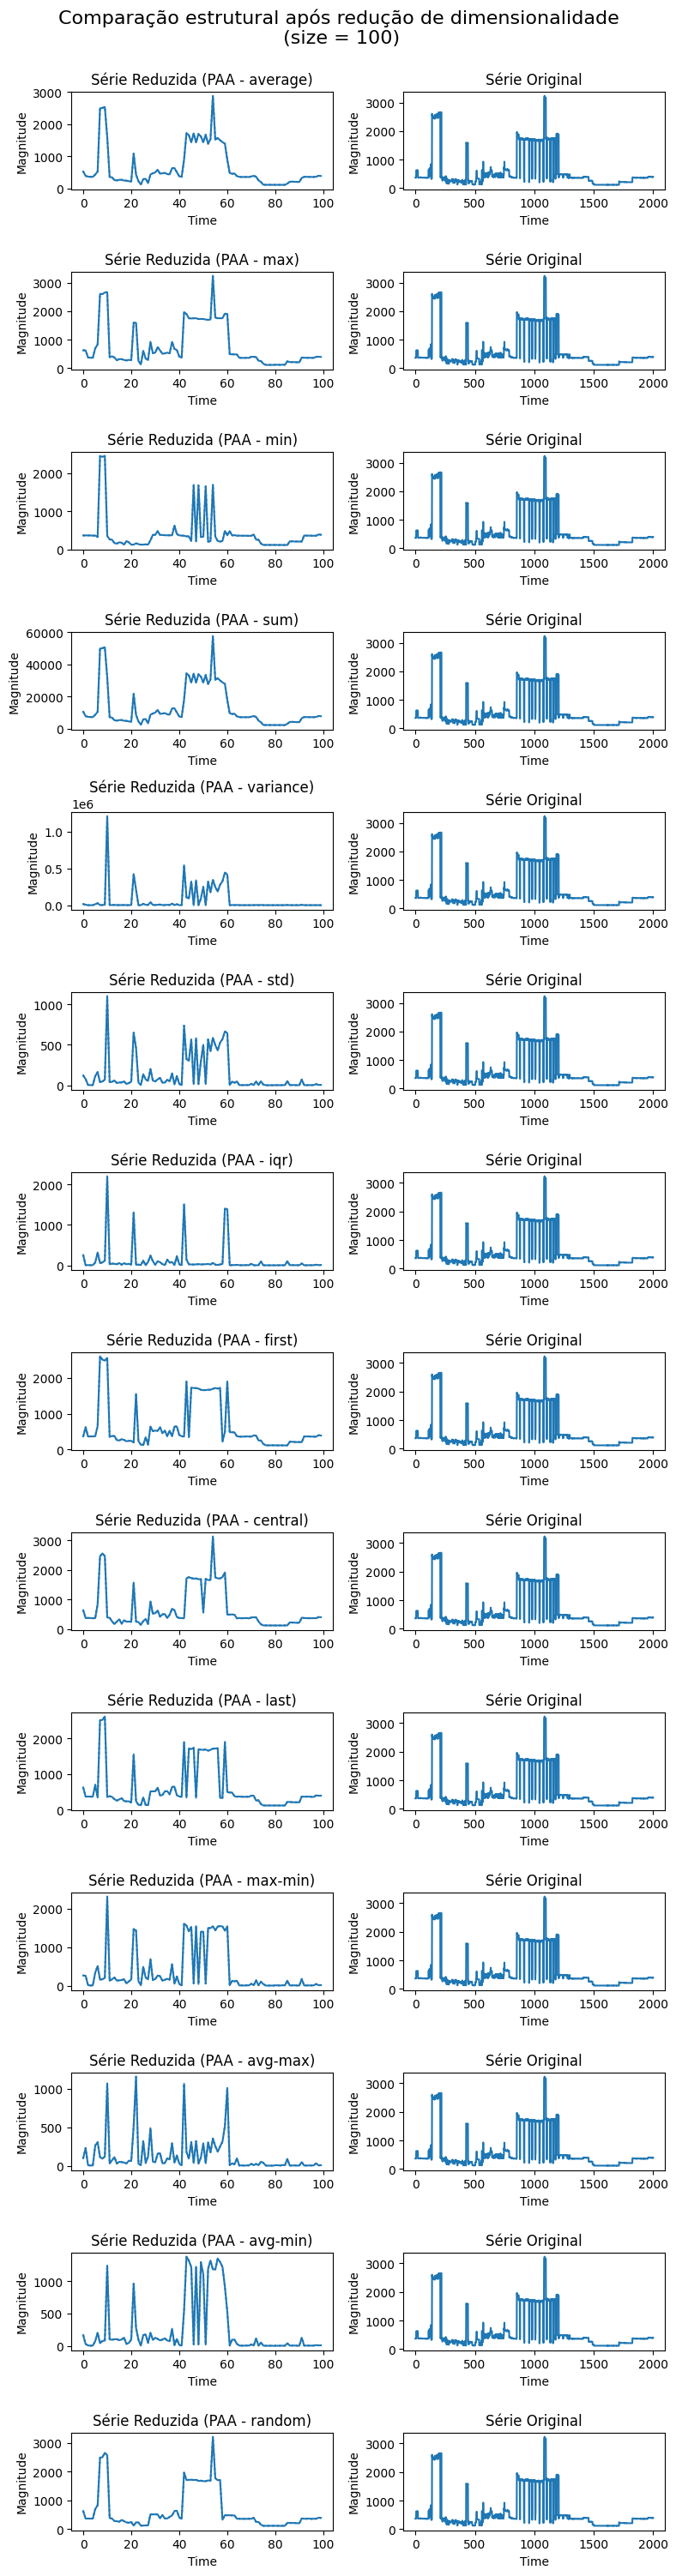

In [ ]:
# Podemos testar o PAA com todos os métodos de agregação na instância 'serie' (idx = 34) do dataset "HouseTwenty" carregada anteriormente
# Neste exemplo vamos aplicar uma redução para 100 pontos
size = 100

# Começamos criando a estrutura de plots com 2 colunas (original e reduzida) e uma linha para cada método de agregação
n_rows = len(aggregations.keys())
n_cols = 2
serie_fig_size = (8, 30)

fig, axes = plt.subplots(n_rows, n_cols, figsize=serie_fig_size)
fig.suptitle('Comparação estrutural após redução de dimensionalidade\n (size = 100)', fontsize=16, y=1)

# Iteramos sobre todos os métodos de agregação que definimos e plota os resultados da redução
for i, method in enumerate(aggregations.keys()):
    reduced = PAA(serie, size, agg=method)

    # Plot da série reduzida
    axes[i, 0].plot(reduced)
    axes[i, 0].set_title(f'Série Reduzida (PAA - {method})')
    axes[i, 0].plot(reduced, linestyle=':', color='tab:blue')
    axes[i, 0].set_xlabel('Time')
    axes[i, 0].set_ylabel('Magnitude')

    # Plot da intancia original para comparação.
    axes[i, 1].plot(serie)
    axes[i, 1].set_title('Série Original')
    axes[i, 1].set_xlabel('Time')
    axes[i, 1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()

Na sequência iremos iremos testar o impacto desta redução nas tarefas de classificação. Para isso iremos aplicar a redução `PAA()` que implementamos em todos os dataset de alta dimensionalidade que separamos anteriormente `high_dim_datasets`. Essa redução sera feita tanto nos dados de teste como de treinamento (X_train e X_test).

Porém, precisamos antes definir quais classificadores serão usados

In [149]:
# Definimos os classificadores a serem usados nos testes, similar ao que fizemos anteriormente para as 'aggregations'
classifiers = {
    'Rocket': RocketClassifier(n_kernels=10000, random_state=42),
    'Catch22': Catch22Classifier()
}

# Definimos as taxas percentuais de redução a serem testadas. (0 ~ 1)
# IMPORTANTE: Testar taxas de redução baixas (proximas de 0) podem implicar em mais demora na hora de rodar os testes de treinamento
# Ex: 
#   - tamanho original de 1000, 
#   - percentual de reducao de 0.1
#   - resulta em 1000 - 100 = 900
reduction_rates = [
    0.95,
    0.9,
    0.5,
]

In [151]:
# Definimos uma função para executar os testes de classificação utilizando o PAA com diferentes métodos de agregação
# A função recebe como argumentos a lista de datasets, a lista de métodos de agregação e a lista de classificadores
def run_paa_tests(datasets, aggregations, classifiers, reduction_rates):
  # Cria a lista de resultados
  results = []
  results_path = './tests/classification/paa/results.csv'

  # Verifica se existem resultados base (sem redução) dos classificadores para evitar retrabalho desnecessário
  baseline_classifiers_results_path = './.cache/classification/results.csv'
  baseline_results_df = pd.DataFrame(columns=['dataset', 'classifier', 'accuracy', 'elapsed_time'])
  if os.path.exists(baseline_classifiers_results_path):
        baseline_results_df = pd.read_csv(baseline_classifiers_results_path)

  # Iteramos sobre cada Dataset
  for d in datasets:
    print(f'[Dataset]: {d}')
    X_train, y_train = load_classification(d, split="train")
    X_test, y_test = load_classification(d, split="test")
    original_size = X_train.shape[2]

    # Executa baseline (sem redução) apenas para referência
    for clf_name, clf in classifiers.items():
        print(f'\t[Classificador]: {clf_name}')
        print(f'\t\t[Sem redução]', end=' ')

        # Verifica se o classificador ja possui o cache dos dados base de treinamento
        baseline_row = baseline_results_df[(baseline_results_df['dataset'] == d) & (baseline_results_df['classifier'] == clf_name)]

        # Se já existe, reutiliza o resultado ao invés de treinar novamente
        if not baseline_row.empty:
            baseline_acc = float(baseline_row['accuracy'].values[0])
            baseline_time = float(baseline_row['elapsed_time'].values[0])
            print(f'-> Resultados do treinamento reutilizado.')
        
        # Se não existe, treina o classificador normalmente
        else:
            start = time.time()
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_test)
            end = time.time()

            baseline_acc = np.round(accuracy_score(y_test, predictions), 4)
            baseline_time = np.round(end - start, 2)
            print(f'-> Treinamento finalizado. ({baseline_time}s)')

            # Adiciona os resultados base (sem redução) do classificador no DataFrame de cache
            row = pd.DataFrame([{
                'dataset': d,
                'classifier': clf_name,
                'accuracy': baseline_acc,
                'elapsed_time': baseline_time
            }])
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=FutureWarning)
                baseline_results_df = pd.concat([baseline_results_df, row], ignore_index=True)
            # Salva o DataFrame de cache em um arquivo CSV para uso posterior
            os.makedirs(os.path.dirname(baseline_classifiers_results_path), exist_ok=True)
            baseline_results_df.to_csv(baseline_classifiers_results_path, index=False)

        # Itera sobre cada taxa de redução definida
        for rate in reduction_rates:
            if rate <= 0 or rate >= 1:
                continue
            
            print(f'\t\t[Taca de reduçao]: {rate*100}%')
            # Define o tamanho 'w' a ser utilizado no PAA como o tamanho original menos a porcentagem de redução
            w = original_size - int((original_size * rate))

            # Itera sobre cada método de agregação definido
            for agg in aggregations.keys():
                print(f'\t\t\t[PAA | {agg}]', end=' ')
                X_train_reduced = np.array([PAA(s[0], w=w, agg=agg) for s in X_train])
                X_test_reduced = np.array([PAA(x[0], w=w, agg=agg) for x in X_test])

                start = time.time()
                clf.fit(X_train_reduced, y_train)
                predictions = clf.predict(X_test_reduced)
                end = time.time()

                acc = np.round(accuracy_score(y_test, predictions), 4)
                elapsed = np.round(end - start, 2)
                reduction_percent = rate
                acc_diff_percent = np.round((acc - baseline_acc) * 100, 2)
                time_diff = np.round(elapsed - baseline_time, 2)

                print(f'-> Treinamento finalizado. ({elapsed}s)')

                results.append({
                    'dataset': d,
                    'classifier': clf_name,
                    'aggregation': agg,
                    'original_size': original_size,
                    'reduced_size': X_train_reduced.shape[1],
                    'reduction_percent': reduction_percent,
                    'accuracy': acc,
                    'original_accuracy': baseline_acc,
                    'acc_diff_percent': acc_diff_percent,
                    'elapsed_time': elapsed,
                    'baseline_time': baseline_time,
                    'time_diff': time_diff
                })

  # Converte os resultados para um DataFrame do Pandas e salva o CSV
  df = pd.DataFrame(results)
  os.makedirs(os.path.dirname(results_path), exist_ok=True)
  df.to_csv(results_path, index=False)

  return df

In [152]:
# Executa os testes apenas no dataset "HouseTwenty" para demonstração
# Para executar os testes em todos os datasets com alta dimensionalidade, substitua a lista de datasets por high_dim_datasets
# IMPORTANTE: A execução dos testes em todos os datasets com alta dimensionalidade pode levar várias horas.
results = run_paa_tests(datasets=['ACSF1', 'HouseTwenty'], aggregations=aggregations, classifiers=classifiers, reduction_rates=reduction_rates)

[Dataset]: ACSF1
	[Classificador]: Rocket
		[Sem redução] -> Resultados do treinamento reutilizado.
		[Taca de reduçao]: 95.0%
			[PAA | average] -> Treinamento finalizado. (1.21s)
			[PAA | max] -> Treinamento finalizado. (1.15s)
			[PAA | min] -> Treinamento finalizado. (1.13s)
			[PAA | sum] -> Treinamento finalizado. (1.14s)
			[PAA | variance] -> Treinamento finalizado. (1.22s)
			[PAA | std] -> Treinamento finalizado. (1.17s)
			[PAA | iqr] -> Treinamento finalizado. (1.13s)
			[PAA | first] -> Treinamento finalizado. (1.15s)
			[PAA | central] -> Treinamento finalizado. (1.19s)
			[PAA | last] -> Treinamento finalizado. (1.13s)
			[PAA | max-min] -> Treinamento finalizado. (1.13s)
			[PAA | avg-max] -> Treinamento finalizado. (1.13s)
			[PAA | avg-min] -> Treinamento finalizado. (1.17s)
			[PAA | random] -> Treinamento finalizado. (1.16s)
		[Taca de reduçao]: 90.0%
			[PAA | average] -> Treinamento finalizado. (2.13s)
			[PAA | max] -> Treinamento finalizado. (2.26s)
			[PAA | m

In [193]:
results.head()

,dataset,classifier,aggregation,original_size,reduced_size,reduction_percent,accuracy,original_accuracy,acc_diff_percent,elapsed_time,baseline_time,time_diff
0,ACSF1,Rocket,average,1460,73,0.95,0.43,0.89,-46.0,1.21,21.0,-19.79
1,ACSF1,Rocket,max,1460,73,0.95,0.29,0.89,-60.0,1.15,21.0,-19.85
2,ACSF1,Rocket,min,1460,73,0.95,0.37,0.89,-52.0,1.13,21.0,-19.87
3,ACSF1,Rocket,sum,1460,73,0.95,0.43,0.89,-46.0,1.14,21.0,-19.86
4,ACSF1,Rocket,variance,1460,73,0.95,0.43,0.89,-46.0,1.22,21.0,-19.78


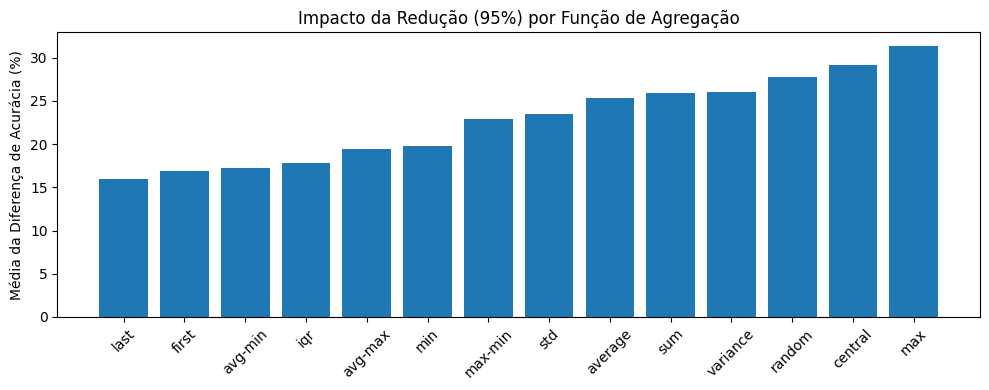

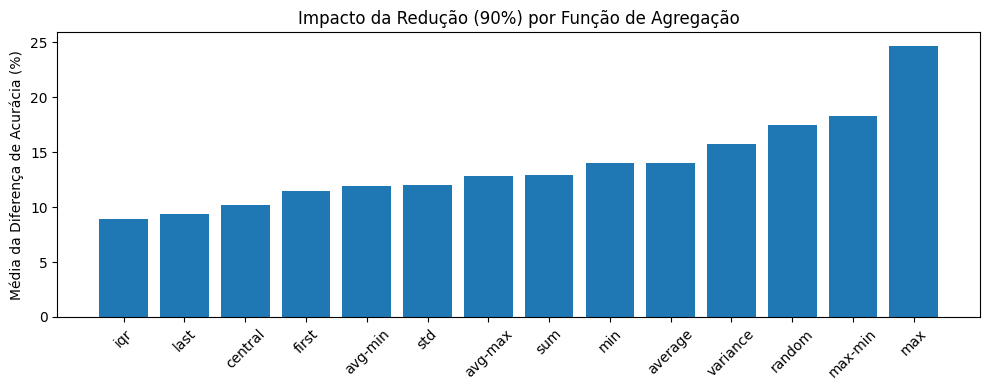

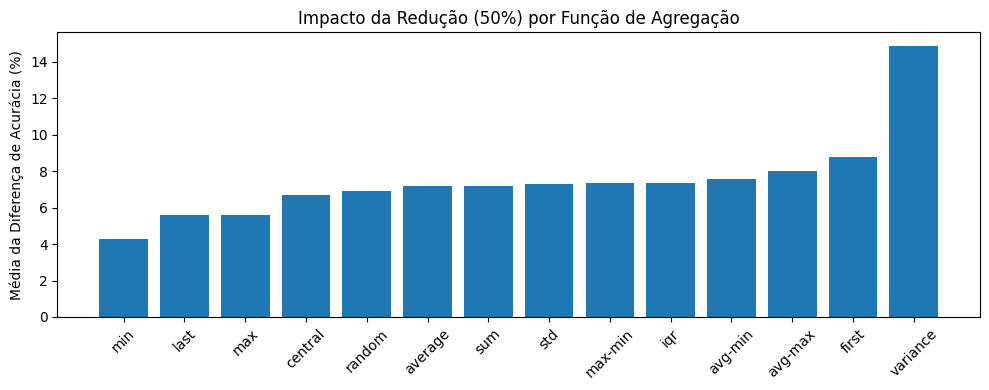

In [254]:
# Seleciona os resultados para reduction_percent == 0.5 e calcula a média da diferença de acurácia por agregação
# Plota o gráfico para cada percentual de redução utilizado
for rate in reduction_rates:
    agg_mean = (
        results[results['reduction_percent'] == rate]
        .groupby('aggregation')['acc_diff_percent']
        .mean()
        .abs()
        .sort_values(ascending=True)
    )

    plt.figure(figsize=(10, 4))
    plt.bar(agg_mean.index, agg_mean.values)
    plt.xticks(rotation=45)
    plt.ylabel('Média da Diferença de Acurácia (%)')
    plt.title(f'Impacto da Redução ({int(rate*100)}%) por Função de Agregação')
    plt.tight_layout()
    plt.show()